# Chapter 2: More on PyMC3

### Model context

- Model variables are associated with a model by defining them in context.

`parameter` -> Exponentially distributed r.v.

`data_generator` -> Poisson distributed r.v. with $\lambda$=`parameter`

In [15]:
import pymc3 as pm
import numpy as np

In [3]:
with model: # To pick up a model again later
    data_plus_one = data_generator + 1 # Pois RV + 1

In [5]:
# Can examine variables outside of model context
parameter.tag.test_value # Initial value of variable
# ^ Can be specified at variable creation time

array(0.49999999904767284)

- Multiple models can be manipulated simultaneously

In [6]:
# Manipulating a separate model:
with pm.Model() as ab_testing:
    sigma = pm.Normal('std', 0, 1)
    p_A = pm.Uniform('p(A)', 0, 1)

Types of programming variables in PyMC3:
- Stochastic variables: variables drawn from a probability distribution (i.e. random variables).
- Deterministic variables: variables that are not random if the variables' parameters and components are known.

### Stochastic Variables

In [10]:
with pm.Model() as model:
    some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
    # Name attribute is used to retrieve posterior distribution later
    # Instead of initializing id. distr. variabels separately...
    # beta_1 = pm.Uniform('beta_1', 0, 1)
    # beta_2 = pm.Uniform('beta_2', 0, 1)
    # ... use the 'shape' argument!
    N = 10
    betas = pm.Uniform('betas', 0, 1, shape=N)


### Deterministic Variables

- Deterministic variables have known values if the parameters to the functions they evaluate from are known.

In [14]:
with model:
    deterministic_variables = pm.Deterministic('deterministic variables',
                                               some_variable*2)

In [5]:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1)
    lambda_2 = pm.Exponential('lambda_2', 1)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

# Elementary operations implicitly create deterministic variables
new_deterministic_variable = lambda_1 + lambda_2
# if lambda_1 and lambda_2 are known, then we know new_det...

In [18]:
import numpy as np

n_data_points = 5
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    
# lambda_ is deterministic
# if we know tau, lambda_1, lambda_2, we know lambda_

- Stochastic variables behave like scalars/numpy arrays within deterministic variables -> can use Theano's tensor operations on them.

In [17]:
def multiply(x, y):
        return np.multiply(x, y) # Hadamard product

with model:
    stoch_1 = pm.Uniform('U_1', 0, 1)
    stoch_2 = pm.Uniform('U_2', 0, 1)

    det_1 = pm.Deterministic('Product', multiply(stoch_1, stoch_2))

### Theano

- Theano builds a compute graph that can be executed at a time of our choosing using `eval()`
- Compute graph is desirable because:
    - We can easily simplify operations
    - We can compile the graph to C
    - We can compile to run on a GPU
    
"PyMC3 is basically a collection of `theano` symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients"

In [4]:
# PyMC3 code with Theano spice
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1) # Theano variable
    p2 = 1 - p1 # ... another Theano variable
    p = tt.stack([[p1, p2]]) # Combines into one Theano variable (a vector)
    # p are category probabilities
    assignment = pm.Categorical('assignment', p) 

### Including observations in the Model

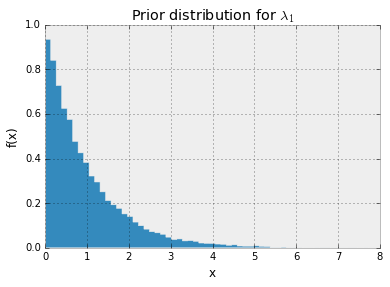

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.style.use('bmh')

samples = [lambda_1.random()[0] for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8);
plt.ylabel('f(x)'); plt.xlabel('x');

1. Get 20 000 samples of `lambda_1`, an Exponential distributed r.v.
2. Plot the observations in a normed histogram $\implies$ plot of the probability density function of the r.v.

To specify the initial values an r.v. takes on, pass the desired values as a `np` or `pd` array to the `observed` argument of the relevant distribution's function.

In [16]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)
print('value: ', fixed_variable.tag.test_value)

value:  [10  5]


In [19]:
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## Modeling approaches

- Start by thinking about how your data might have been generated: how would you recreate the data?

Text messaging Poisson process modeling example:
1. What is the best random variable to describe this count data? A Poisson r.v. was a good choice because it can count the total occurences of an event in a timeframe (e.g. a day).
2. Next, what are the parameters of the Poisson distribution? Here there's only one: the rate parameter, $\lambda$.
3. Is $\lambda$ known? No, it was though there might be two different values for $\lambda$, one for earlier in the time series and one for later. We think it might switch at some point, but we're not sure when. Call the switchpoint $\tau$.
4. What is a good distribution for the Poisson parameters? The Exponential is good, as it assigns probabilities to positive real numbers only. The Exponential distribution also has a parameter too though, $\alpha$.
5. We don't know $\alpha$, nor do we really know what $\alpha$ might be. Here we draw the line, and assign $\alpha$ a fixed value.

What is a good value for $\alpha$? Using our data, we can establish that the $\lambda$ values are between 10-30, so we should choose $\alpha$ such that the mean of $\lambda$ given $\alpha$ is equal to the observed mean.

We also need to figure out how what $\tau$ might be. We could guess this, but a Discrete Uniform distribution over the timespan is just fine.

<img src='http://i.imgur.com/7J30oCG.png'/>

This is a graph of our model. We can think of this as a data-generation 'story': $\alpha$ is used to generate two Poisson parameters from an Exponential distribution, which constitute the distribution of the rate parameter over the entire time series. $\tau$ contributes to this distribution by indicating when the switchover occurs.

If we reverse the above derivation of how the data might have been generated, we can create our own data generation process.

1. Get a switchover value.

In [20]:
tau = np.random.randint(0, 80) # Value of a Uniform dist r.v.
print(tau)

9


/2. Draw two rate parameters from an Exponential distribution.

In [21]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

12.8061154188 6.20251122955


/3. Make observations according to these Poisson distributions before and after the switchover.

In [25]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80-tau)]

/4. Plot the artificial data:

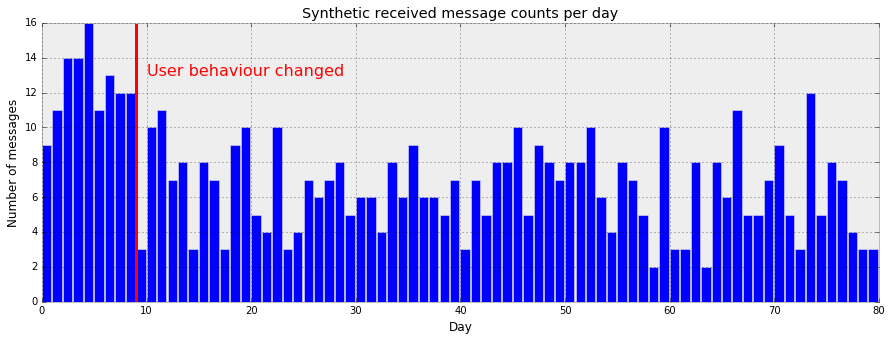

In [47]:
plt.figure(figsize=(15, 5))
plt.title('Synthetic received message counts per day')
plt.bar(range(80), data, width=0.9)
plt.xlabel('Day'); plt.ylabel('Number of messages')
plt.axvline(x=tau, ymax=max(data), color='r', lw=3);
plt.text(tau+1, max(data)-3, 'User behaviour changed', color='r', size=16);

PyMC3 is designed to find parameters that will match our generated data against our observed data.

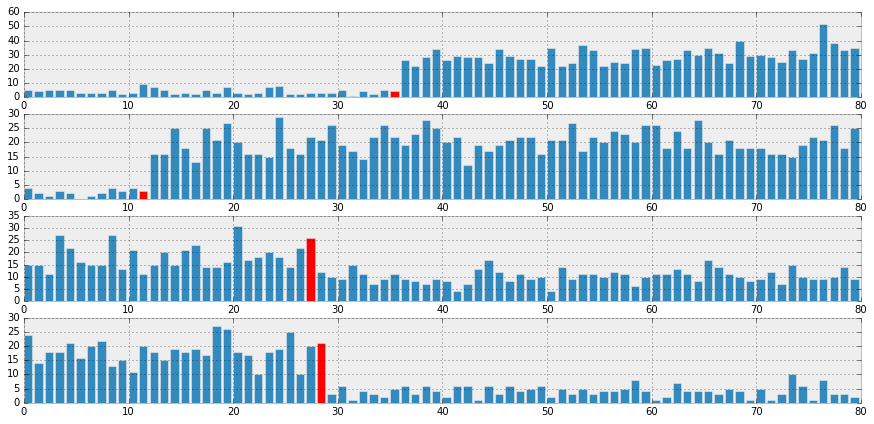

In [50]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);

plt.figure(figsize=(15, 7))
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

### Example: Bayesian A/B testing